In [1]:
!pip install git+https://github.com/Qip21n0/Lassolver.git

  Cloning https://github.com/Qip21n0/Lassolver.git to /tmp/pip-req-build-j58k4d6h
  Running command git clone -q https://github.com/Qip21n0/Lassolver.git /tmp/pip-req-build-j58k4d6h
  Created wheel for lassolver: filename=lassolver-0.2.6-py3-none-any.whl size=14036 sha256=84fad276ee6c321c66f1467d306f7e17511ef19f7a8a815d42fdb7f019d7daa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-iia23h0h/wheels/5c/0b/77/92d6595822ec0c5e1c27d209f3bcae9296385c30ce4a38cf06
Successfully built lassolver


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP
from lassolver.dsolver.d_base import dbase, D_Base

In [3]:
!pip show lassolver

Name: lassolver
Version: 0.2.6
Summary: Lassolver is a Python package for Compressed Sensing and Distributed Compressed Sensing
Home-page: https://github.com/Qip21n0/Lassolver
Author: Ken Hisanaga
Author-email: UNKNOWN
License: MIT
Location: /home/ryota/.local/lib/python3.8/site-packages
Requires: numpy, matplotlib, scipy
Required-by: 


In [4]:
def gcoamp(w, tau_p, log=False, ord=None):
    shita = 0.7
    tau = np.sum(tau_p)
    communication_cost = 0
    P, N, _ = w.shape
    R = np.zeros((P, N, 1))
    z = [0] * N
    
    #STEP1
    for p in range(1, P):
        R[p] = np.square(w[p]) > tau_p[p] * shita
        candidate = np.where(R[p])[0]
        for n in candidate:
            communication_cost += 1
            send_to1(n, w[p, n])
    
    #STEP2
    S = [np.where(R[:, n])[0] for n in range(N)]
    m = np.sum(R, axis=0)
    U = np.empty((N, 1))
    for n in range(N):
        upper = np.sum([tau_p[p] for p in range(1, P) if p not in S[p]])
        z[n] = w[0, n] + np.sum([w[p, n] for p in S[n]])
        U[n] = z[n]**2 + upper * shita
    F = (U > tau) * (m < (P-1))
    candidate = np.where(F)[0]
    for n in candidate:
        communication_cost += 1
        broadcast_others(n)
    
    #STEP3
    F_R = F * np.logical_not(R)
    for p in range(1, P):
        #print("p: {}".format(p))
        candidate = np.where(F_R[p])[0]
        for n in candidate:
            communication_cost += 1
            send_to1(n ,w[p, n])
    if log: 
        print("Rp: {} \t F: {} \t F\\Rp: {}".format(np.sum(R), np.sum(F), np.sum(F_R)-np.sum(F)))
        print("Total Communication Cost: {}".format(communication_cost))
        print("="*50)
    
    #STEP4
    u = np.zeros((N, 1))
    b = np.zeros((N, 1))
    V = np.where(U > tau)[0].tolist()
    for n in V:
        b[n] = np.sum(w[:, n])
        u[n] = soft_threshold(b[n], tau**0.5)
    
    #STEP5
    Vc = [n for n in range(N) if n not in V]
    z_exe = {'0', '1'}
    rand_exe = {'0', '2'}
    for n in Vc:
        b[n] = z[n] if ord in z_exe else 0
        b[n] += np.sum([rand(shita * tau_p[p]) for p in range(1, P) if p not in S[n]]) if ord in rand_exe else 0
        b[n] = np.sum([w[p, n] for p in range(1, P) if p not in S[n]]) if ord == '4' else b[n]
        
    s = u - np.mean(u != 0)*b
    return s.real, communication_cost

In [5]:
class dtest(dbase):
    def __init__(self, A_p, x, snr, M):
        super().__init__(A_p, x, snr, M)

    def receive_s(self, s):
        self.s = s.copy()

    def receive_W_p(self, W_p):
        self.W_p = W_p.copy()

    def receive_trX2(self, trW_p2, trB2):
        self.trW_p2 = trW_p2
        self.trB2 = trB2

    def receive_trA2(self, trA2):
        self.trA2 = trA2

    def local_compute(self):
        self.r_p = self._update_r_p()
        w_p = self._update_w_p()
        v_p = self._update_v_p()
        tau_p = self._update_tau_p(v_p)
        return w_p, v_p, tau_p

    def _update_r_p(self):
        return self.y - self.A_p @ self.s

    def _update_w_p(self):
        return self.s / self.P + self.W_p @ self.r_p

    def _update_v_p(self):
        v_p = (np.linalg.norm(self.r_p)**2 - self.M_p * self.sigma_p) / self.trA2
        return v_p

    def _update_tau_p(self, v_p):
        return 1 / self.N * (self.trB2 * v_p + self.trW_p2 * self.sigma_p)

In [6]:
class D_Test(D_Base):
    def __init__(self, A, x, noise, P):
        super().__init__(A, x, noise, P)
        self.A = A.copy()
        self.AT = self.A.T
        self.AAT = self.A @ self.AT
        self.I = np.eye(self.M)
        self.c = (self.N - self.M) / self.M
        self.oamps = [dtest(self.A_p[p], x, self.noise[p], self.M) for p in range(self.P)]
        self.sigma = self.__set_sigma()
        self.trA2 = self.__set_trA2()

    def __set_sigma(self):
        sigma = 0
        for p in range(self.P):
            sigma += self.oamps[p].sigma_p
        return sigma / self.P
    
    def __set_trA2(self):
        trA2 = 0
        for p in range(self.P):
            trA2 += self.oamps[p].trA2_p
        return trA2

    def estimate(self, T=20, C=1.85, ord='LMMSE', log=False, gctype=None):
        self.gctype = gctype
        w = np.zeros((self.P, self.N, 1))

        v = (np.sum([np.linalg.norm(self.oamps[p].y)**2 for p in range(self.P)]) - self.M_p * self.sigma) / self.trA2
        self.W = self.__set_W(v, ord)
        self.W_p = self.W.T.reshape(self.P, self.M_p, self.N)
        
        I = np.eye(self.N)
        B = I - self.W @ self.A
        self.trW2 = [np.trace(W_p.T @ W_p) for W_p in self.W_p]
        self.trB2 = np.trace(B @ B.T)

        for p in range(self.P):
            self.oamps[p].receive_W_p(self.W_p[p].T)
            self.oamps[p].receive_trX2(self.trW2[p], self.trB2)
            self.oamps[p].receive_trA2(self.trA2)
        
        for t in range(T):
            for p in range(self.P):
                w[p], self.v_p[p], self.tau_p[p] = self.oamps[p].local_compute()
            #w[0] += self.s
            v = self._update_v()
            tau = self._update_tau()
            if log: print("{}/{}: tau = {}, v = {}".format(t+1, T, tau, v))
            self._update_s(C, w, log)

            for p in range(self.P):
                self.oamps[p].receive_s(self.s)
            self._add_mse()
            if t == T-1: break
            if ord == 'LMMSE':
                self.W = self.__set_W(v, ord='LMMSE')
                self.W_p = self.W.T.reshape(self.P, self.M_p, self.N)
                B = I - self.W @ self.A
                self.trW2 = [np.trace(W_p.T @ W_p) for W_p in self.W_p]
                self.trB2 = np.trace(B @ B.T)
                for p in range(self.P):
                    self.oamps[p].receive_W_p(self.W_p[p].T)
                    self.oamps[p].receive_trX2(self.trW2[p], self.trB2)
        
        #self._output_s(w, log)
        #self._add_mse()

    def __set_W(self, v, ord):
        if ord == 'MF':
            W_ = self.AT
        elif ord == 'PINV':
            W_ = np.linalg.pinv(self.A)
        elif ord == 'LMMSE':
            W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
        else :
            raise NameError("not correct")
        return self.N / np.trace(W_ @ self.A) * W_

    def _update_v(self):
        #r2 = np.sum(self.r2)
        #v = (r2 - self.M * self.sigma) / self.trA2
        v = np.sum(self.v_p)
        v = v if v > 0 else 1e-4
        self.v.append(v)
        return v

    def _update_tau(self):
        #return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)
        return np.sum(self.tau_p)

    def _update_s(self, C, w, log):
        s, communication_cost = gcoamp(w, self.tau_p, log, self.gctype)
        self.s = C * s
        self.communication_cost = np.append(self.communication_cost, communication_cost)

    def _output_s(self, w, log):
        s, communication_cost = GCAMP(w, self.tau_p, log)
        self.s = s
        self.communication_cost = np.append(self.communication_cost, communication_cost)

In [26]:
N = 4000
alpha = 0.5
M = int(alpha*N)
rho = 0.2

In [28]:
kappa = 5
P = 2
T = 40

In [29]:
x = bernouli_gaussian(N, rho)
SNR = 60
mode = 'LMMSE'

In [30]:
iidG = iidGaussian(M, N, 0, 1/M)
SNRdB = 10**(0.1*SNR)
sigma = np.linalg.norm(iidG.A @ x)**2 / SNRdB
noise = np.random.normal(0, sigma**0.5, (M, 1))

In [31]:
oamp = OAMP(iidG.A, x, noise)
test = [D_Test(iidG.A, x, noise, P) for _ in range(5)]

In [32]:
%%prun
oamp.estimate(T=T, ord=mode)

         4506 function calls (4345 primitive calls) in 82.541 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   44.355   44.355   82.540   82.540 oamp.py:13(estimate)
       40   23.754    0.594   37.304    0.933 oamp.py:40(__set_W)
       40   13.539    0.338   13.542    0.339 linalg.py:476(inv)
       40    0.533    0.013    0.535    0.013 twodim_base.py:161(eye)
       40    0.153    0.004    0.153    0.004 ista.py:39(_update_r)
       40    0.147    0.004    0.147    0.004 oamp.py:51(_update_w)
      161    0.036    0.000    0.036    0.000 {method 'trace' of 'numpy.ndarray' objects}
  523/362    0.003    0.000   13.589    0.038 {built-in method numpy.core._multiarray_umath.implement_array_function}
       40    0.003    0.000    0.003    0.000 func.py:5(soft_threshold)
       81    0.002    0.000    0.004    0.000 linalg.py:2363(norm)
       40    0.001    0.000    0.007    0.000 func.py:12(df)
       40    0.

final mse: 0.026929856521446277


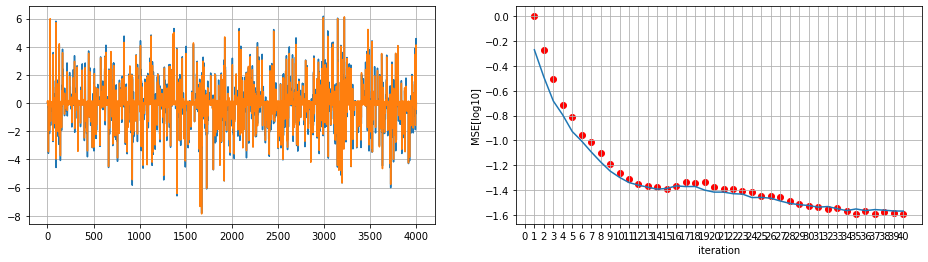

In [33]:
oamp.result()

## $z[n]$と乱数を含む手法(現提案手法)

In [34]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[0].estimate(T=T, ord=mode, log=True, gctype='0')

N(P-1): 4000

1/40: tau = 1.0115687271881315, v = 1.003338281206287
Rp: 2475.0 	 F: 470 	 F\Rp: 470
Total Communication Cost: 3415
2/40: tau = 0.47206013810289366, v = 0.4638475333285571
Rp: 2536.0 	 F: 430 	 F\Rp: 430
Total Communication Cost: 3396
3/40: tau = 0.2945662053021665, v = 0.286400523449711
Rp: 2553.0 	 F: 451 	 F\Rp: 451
Total Communication Cost: 3455
4/40: tau = 0.18736631914344568, v = 0.17925750684989084
Rp: 2574.0 	 F: 472 	 F\Rp: 472
Total Communication Cost: 3518
5/40: tau = 0.1400521354264908, v = 0.13201031016365763
Rp: 2585.0 	 F: 403 	 F\Rp: 403
Total Communication Cost: 3391
6/40: tau = 0.1074198687062419, v = 0.09944606327687548
Rp: 2520.0 	 F: 446 	 F\Rp: 446
Total Communication Cost: 3412
7/40: tau = 0.07703865131922982, v = 0.06916386198212997
Rp: 2582.0 	 F: 423 	 F\Rp: 423
Total Communication Cost: 3428
8/40: tau = 0.05975521415014335, v = 0.05200121428430385
Rp: 2566.0 	 F: 418 	 F\Rp: 418
Total Communication Cost: 3402
9/40: tau = 0.04857194097206791, v 

         12610188 function calls (12609906 primitive calls) in 111.569 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   39.298   39.298  111.568  111.568 2242291230.py:25(estimate)
       40   24.063    0.602   36.087    0.902 2242291230.py:69(__set_W)
       39   17.441    0.447   17.454    0.448 2242291230.py:60(<listcomp>)
       40   12.014    0.300   12.015    0.300 linalg.py:476(inv)
       40    2.389    0.060   17.345    0.434 1962848297.py:1(gcoamp)
   742579    2.213    0.000    2.213    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       40    1.832    0.046    1.832    0.046 1962848297.py:53(<listcomp>)
   742539    1.144    0.000    4.075    0.000 fromnumeric.py:69(_wrapreduction)
1253047/1252765    1.061    0.000   18.990    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    43703    0.882    0.000    2.360    0.000 _continuous_distns.py:8003(_truncnorm_ppf_scalar)

final mse: 0.011987600172081865


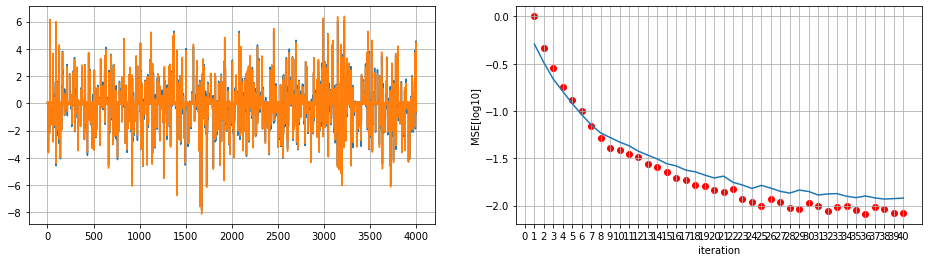

In [35]:
test[0].result()

## $z[n]$は含むが, 乱数は含まない手法

In [36]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[1].estimate(T=T, ord=mode, log=True, gctype='1')

N(P-1): 4000

1/40: tau = 1.0115687271881315, v = 1.003338281206287
Rp: 2475.0 	 F: 470 	 F\Rp: 470
Total Communication Cost: 3415
2/40: tau = 0.4622482975837906, v = 0.4540360172801751
Rp: 2513.0 	 F: 443 	 F\Rp: 443
Total Communication Cost: 3399
3/40: tau = 0.29217736683350065, v = 0.28401316374366825
Rp: 2560.0 	 F: 455 	 F\Rp: 455
Total Communication Cost: 3470
4/40: tau = 0.1794417949097491, v = 0.1713367187614416
Rp: 2577.0 	 F: 491 	 F\Rp: 491
Total Communication Cost: 3559
5/40: tau = 0.13559072856361554, v = 0.12755697518948222
Rp: 2593.0 	 F: 422 	 F\Rp: 422
Total Communication Cost: 3437
6/40: tau = 0.10118703948360169, v = 0.09322736595381366
Rp: 2546.0 	 F: 456 	 F\Rp: 456
Total Communication Cost: 3458
7/40: tau = 0.08128541048272112, v = 0.07340663832063789
Rp: 2566.0 	 F: 429 	 F\Rp: 429
Total Communication Cost: 3424
8/40: tau = 0.061453346201993345, v = 0.05368163892658039
Rp: 2596.0 	 F: 410 	 F\Rp: 410
Total Communication Cost: 3416
9/40: tau = 0.05157937030453359,

         4876038 function calls (4875756 primitive calls) in 104.664 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   39.737   39.737  104.662  104.662 2242291230.py:25(estimate)
       40   23.726    0.593   37.183    0.930 2242291230.py:69(__set_W)
       39   17.234    0.442   17.243    0.442 2242291230.py:60(<listcomp>)
       40   13.448    0.336   13.449    0.336 linalg.py:476(inv)
       40    1.992    0.050    9.104    0.228 1962848297.py:1(gcoamp)
       40    1.842    0.046    1.842    0.046 1962848297.py:53(<listcomp>)
   393141    1.253    0.000    1.253    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   160000    0.759    0.000    0.759    0.000 1962848297.py:22(<listcomp>)
   393101    0.611    0.000    2.196    0.000 fromnumeric.py:69(_wrapreduction)
553985/553703    0.583    0.000   16.750    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.460    0.

final mse: 0.010668985822726764


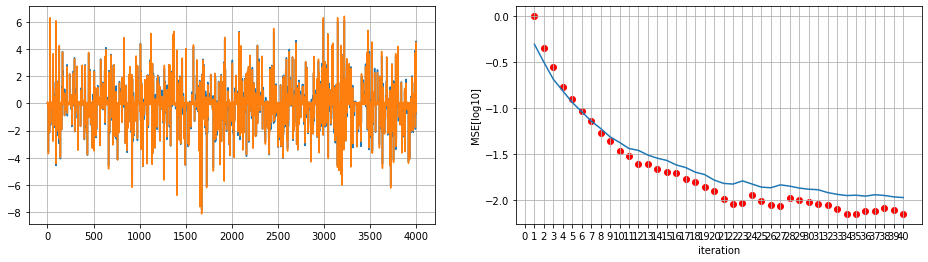

In [37]:
test[1].result()

## $z[n]$は含まないが, 乱数は含む手法

In [38]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[2].estimate(T=T, ord=mode, log=True, gctype='2')

N(P-1): 4000

1/40: tau = 1.0115687271881315, v = 1.003338281206287
Rp: 2475.0 	 F: 470 	 F\Rp: 470
Total Communication Cost: 3415
2/40: tau = 0.2777462511114248, v = 0.2695400721617743
Rp: 2574.0 	 F: 474 	 F\Rp: 474
Total Communication Cost: 3522
3/40: tau = 0.23373421337263722, v = 0.22561012550522835
Rp: 2545.0 	 F: 486 	 F\Rp: 486
Total Communication Cost: 3517
4/40: tau = 0.1277351148599277, v = 0.11967844359367713
Rp: 2578.0 	 F: 486 	 F\Rp: 486
Total Communication Cost: 3550
5/40: tau = 0.12283119853947239, v = 0.11483555430854417
Rp: 2555.0 	 F: 454 	 F\Rp: 454
Total Communication Cost: 3463
6/40: tau = 0.07069224662051979, v = 0.06280735677777072
Rp: 2599.0 	 F: 434 	 F\Rp: 434
Total Communication Cost: 3467
7/40: tau = 0.0786093440065569, v = 0.07075302668778596
Rp: 2543.0 	 F: 449 	 F\Rp: 449
Total Communication Cost: 3441
8/40: tau = 0.052715915358846475, v = 0.04499343968848986
Rp: 2596.0 	 F: 448 	 F\Rp: 448
Total Communication Cost: 3492
9/40: tau = 0.05899540749885098,

         12257096 function calls (12256814 primitive calls) in 115.592 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   39.589   39.589  115.591  115.591 2242291230.py:25(estimate)
       40   25.490    0.637   38.798    0.970 2242291230.py:69(__set_W)
       39   17.832    0.457   17.843    0.458 2242291230.py:60(<listcomp>)
       40   13.298    0.332   13.299    0.332 linalg.py:476(inv)
       40    2.507    0.063   17.946    0.449 1962848297.py:1(gcoamp)
   728941    2.274    0.000    2.274    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       40    2.012    0.050    2.012    0.050 1962848297.py:53(<listcomp>)
   728901    1.181    0.000    4.229    0.000 fromnumeric.py:69(_wrapreduction)
1221225/1220943    1.117    0.000   20.483    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    41430    0.868    0.000    2.318    0.000 _continuous_distns.py:8003(_truncnorm_ppf_scalar)

final mse: 0.04014432098064563


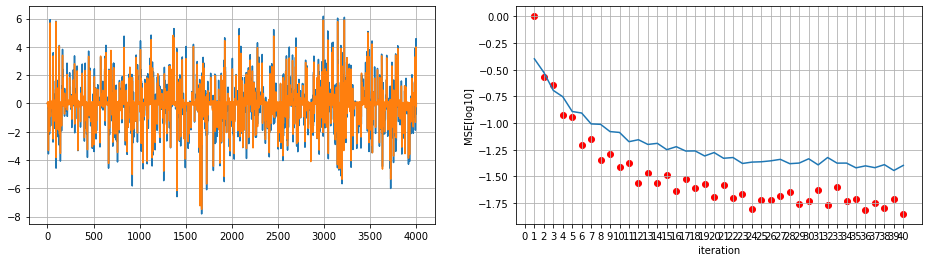

In [39]:
test[2].result()

## $z[n]$も乱数も含まない手法

In [40]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[3].estimate(T=T, ord=mode, log=True, gctype='3')

N(P-1): 4000

1/40: tau = 1.0115687271881315, v = 1.003338281206287
Rp: 2475.0 	 F: 470 	 F\Rp: 470
Total Communication Cost: 3415
2/40: tau = 0.26580808550824614, v = 0.25760230134540385
Rp: 2582.0 	 F: 473 	 F\Rp: 473
Total Communication Cost: 3528
3/40: tau = 0.23794141238023692, v = 0.22981682469741657
Rp: 2567.0 	 F: 458 	 F\Rp: 458
Total Communication Cost: 3483
4/40: tau = 0.12035412174859697, v = 0.11229950102774128
Rp: 2590.0 	 F: 494 	 F\Rp: 494
Total Communication Cost: 3578
5/40: tau = 0.1188235947895698, v = 0.11083703808923429
Rp: 2584.0 	 F: 447 	 F\Rp: 447
Total Communication Cost: 3478
6/40: tau = 0.07556670564298265, v = 0.06767784033949346
Rp: 2561.0 	 F: 471 	 F\Rp: 471
Total Communication Cost: 3503
7/40: tau = 0.0660151386168081, v = 0.058230692011306893
Rp: 2551.0 	 F: 450 	 F\Rp: 450
Total Communication Cost: 3451
8/40: tau = 0.051134001827411776, v = 0.04345974210392889
Rp: 2587.0 	 F: 471 	 F\Rp: 471
Total Communication Cost: 3529
9/40: tau = 0.057217840652271

         4908667 function calls (4908385 primitive calls) in 109.126 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   40.591   40.591  109.124  109.124 2242291230.py:25(estimate)
       40   25.137    0.628   39.268    0.982 2242291230.py:69(__set_W)
       39   17.661    0.453   17.670    0.453 2242291230.py:60(<listcomp>)
       40   14.120    0.353   14.122    0.353 linalg.py:476(inv)
       40    2.235    0.056   10.036    0.251 1962848297.py:1(gcoamp)
       40    2.081    0.052    2.081    0.052 1962848297.py:53(<listcomp>)
   396182    1.360    0.000    1.360    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   160000    0.850    0.000    0.850    0.000 1962848297.py:22(<listcomp>)
   396142    0.708    0.000    2.446    0.000 fromnumeric.py:69(_wrapreduction)
557026/556744    0.590    0.000   17.734    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   396142    0.479    0.

final mse: 0.04031410914385861


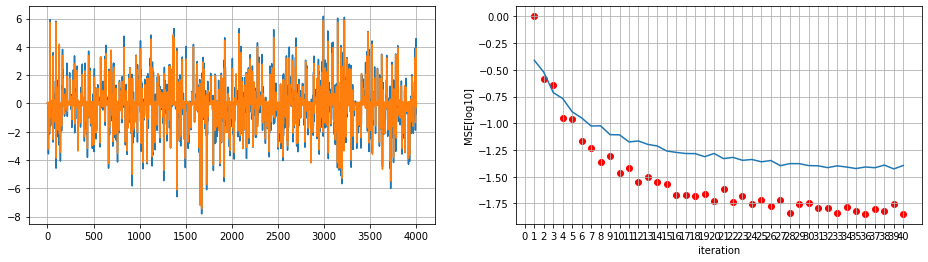

In [41]:
test[3].result()

## イレギュラーな値$b[n] = \sum_{p \ge 2, p \notin S_n} w^t_p [n]$を用いる手法

In [42]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[4].estimate(T=T, ord=mode, log=True, gctype='4')

N(P-1): 4000

1/40: tau = 1.0115687271881315, v = 1.003338281206287
Rp: 2475.0 	 F: 470 	 F\Rp: 470
Total Communication Cost: 3415
2/40: tau = 0.29288589162076517, v = 0.2846792120137647
Rp: 2548.0 	 F: 506 	 F\Rp: 506
Total Communication Cost: 3560
3/40: tau = 0.24881623359795552, v = 0.24068411816620486
Rp: 2535.0 	 F: 452 	 F\Rp: 452
Total Communication Cost: 3439
4/40: tau = 0.1302578594896864, v = 0.12219193572455565
Rp: 2582.0 	 F: 460 	 F\Rp: 460
Total Communication Cost: 3502
5/40: tau = 0.11057021744067827, v = 0.10259731616311357
Rp: 2607.0 	 F: 431 	 F\Rp: 431
Total Communication Cost: 3469
6/40: tau = 0.07700957822092505, v = 0.06913010418963893
Rp: 2571.0 	 F: 450 	 F\Rp: 450
Total Communication Cost: 3471
7/40: tau = 0.07260597499044938, v = 0.06478536341774285
Rp: 2555.0 	 F: 435 	 F\Rp: 435
Total Communication Cost: 3425
8/40: tau = 0.05661158919025726, v = 0.04888499014322452
Rp: 2610.0 	 F: 437 	 F\Rp: 437
Total Communication Cost: 3484
9/40: tau = 0.05256947828974757

         5833833 function calls (5833551 primitive calls) in 108.514 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   39.098   39.098  108.512  108.512 2242291230.py:25(estimate)
       40   24.932    0.623   39.068    0.977 2242291230.py:69(__set_W)
       39   17.598    0.451   17.608    0.451 2242291230.py:60(<listcomp>)
       40   14.126    0.353   14.127    0.353 linalg.py:476(inv)
       40    2.383    0.060   11.090    0.277 1962848297.py:1(gcoamp)
       40    2.062    0.052    2.062    0.052 1962848297.py:53(<listcomp>)
   480361    1.642    0.000    1.642    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   160000    0.843    0.000    0.843    0.000 1962848297.py:22(<listcomp>)
   480321    0.778    0.000    2.868    0.000 fromnumeric.py:69(_wrapreduction)
641205/640923    0.665    0.000   18.304    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      160    0.541    0.

final mse: 0.030812180248458002


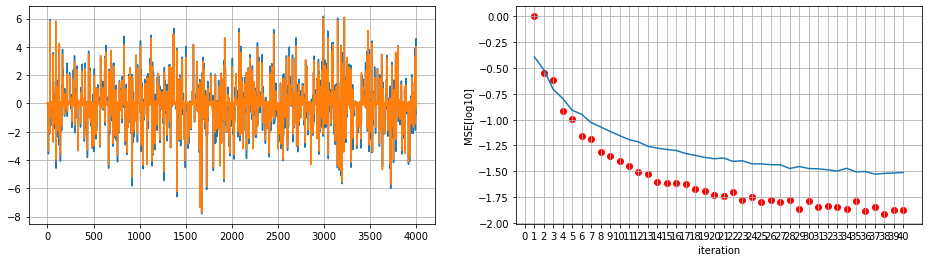

In [43]:
test[4].result()

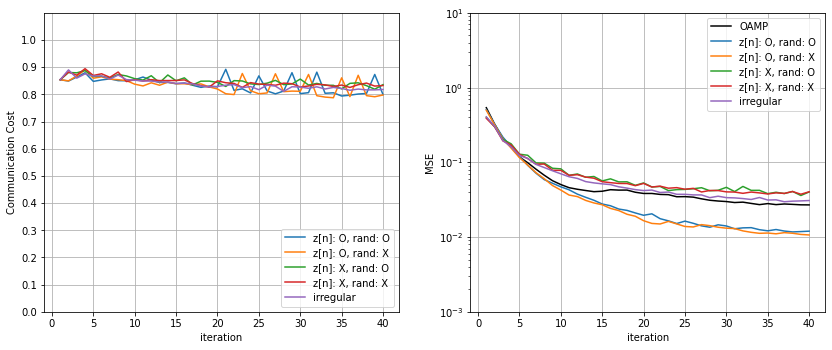

In [44]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt_CC(test[0].communication_cost, 'z[n]: O, rand: O', T, N, P)
plt_CC(test[1].communication_cost, 'z[n]: O, rand: X', T, N, P)
plt_CC(test[2].communication_cost, 'z[n]: X, rand: O', T, N, P)
plt_CC(test[3].communication_cost, 'z[n]: X, rand: X', T, N, P)
plt_CC(test[4].communication_cost, 'irregular', T, N, P)
plt.grid()

plt.subplot(122)
plt_MSE(oamp.mse, 'OAMP', T, 'black')
plt_MSE(test[0].mse, 'z[n]: O, rand: O', T)
plt_MSE(test[1].mse, 'z[n]: O, rand: X', T)
plt_MSE(test[2].mse, 'z[n]: X, rand: O', T)
plt_MSE(test[3].mse, 'z[n]: X, rand: X', T)
plt_MSE(test[4].mse, 'irregular', T)
plt.grid()

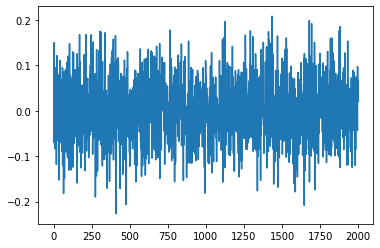

In [45]:
oamp_noise = oamp.n.copy().flatten()
plt.plot(oamp_noise)

In [46]:
test_noise = []
for i in range(5):
  n = np.empty(0)
  for p in range(P):
    n = np.append(n, test[i].oamps[p].y - test[i].oamps[p].A_p @ x)
  test_noise.append(n.flatten())

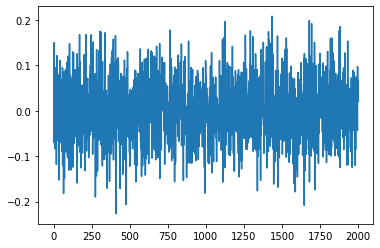

In [47]:
plt.plot(test_noise[0])

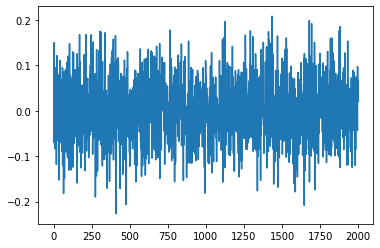

In [48]:
plt.plot(test_noise[1])

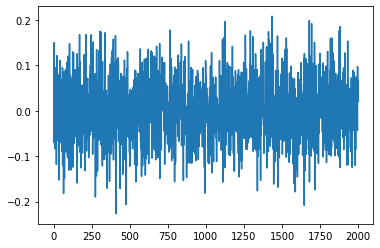

In [49]:
plt.plot(test_noise[2])

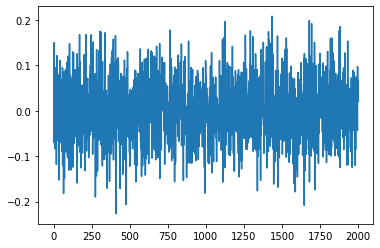

In [50]:
plt.plot(test_noise[3])

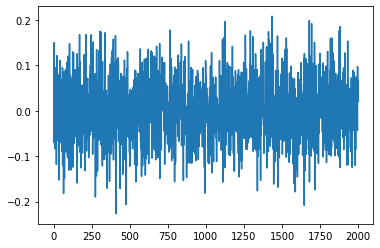

In [52]:
plt.plot(test_noise[4])

In [53]:
for i in range(5):
  norm = np.linalg.norm(oamp_noise - test_noise[i])
  print(norm)

2.9830333134160885e-15
2.9830333134160885e-15
2.9830333134160885e-15
2.9830333134160885e-15
2.9830333134160885e-15


In [54]:
N = 4000  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [55]:
SNR = 60  # 信号対雑音比
SNRdB = 10**(0.1*SNR)
kappa = 5  # 条件数
P = 2  # ノード数
T = 40  # 反復回数
sim = 100  # 実験数

In [56]:
xs = [bernouli_gaussian(N, rho) for _ in range(sim)]
l = 5
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']

In [57]:
MSE_iidG_oamp = np.empty((sim, T+1))

MSE_iidG_test = np.empty((sim, 5, T+1))
CommCost_iidG_test = np.empty((sim, 5, T))

In [58]:
for i in tqdm(range(sim)):
    iidG = iidGaussian(M, N, m=0, v=1/M)
    Ax = iidG.A @ xs[i]
    sigma = np.linalg.norm(Ax)**2 / SNRdB
    noise = np.random.normal(0, sigma**0.5, (M, 1))

    oamp = D_OAMP(iidG.A, xs[i], noise, 1)
    test = [D_Test(iidG.A, xs[i], noise, P) for _ in range(5)]

    oamp.estimate(T=T)
    MSE_iidG_oamp[i] = oamp.mse

    for j in range(5):
        test[j].estimate(T, gctype=str(j))
        MSE_iidG_test[i, j] = test[j].mse
        CommCost_iidG_test[i, j] = test[j].communication_cost

100%|██████████| 100/100 [11:47:08<00:00, 424.28s/it] 


In [59]:
MSE_iidG_oamp_mean = np.mean(MSE_iidG_oamp, axis=0)

MSE_iidG_test_mean = np.empty((5, T+1))
CommCost_iidG_test_mean = np.empty((5, T))

for i in range(5):
    MSE_iidG_test_mean[i] = np.mean(MSE_iidG_test[:, i], axis=0)
    CommCost_iidG_test_mean[i] = np.mean(CommCost_iidG_test[:, i], axis=0)

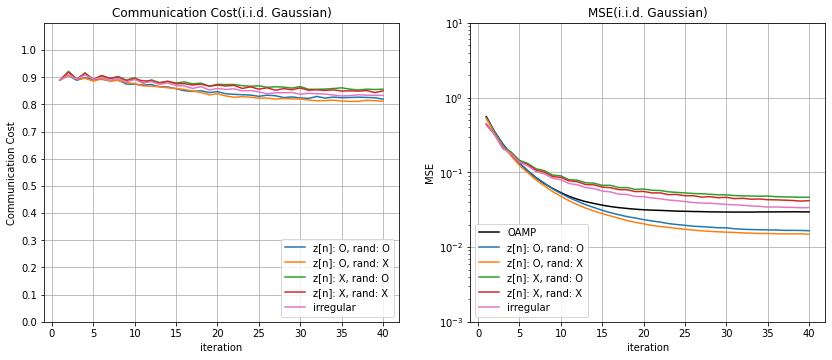

In [60]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt.title('Communication Cost(i.i.d. Gaussian)')
plt_CC(CommCost_iidG_test_mean[0], 'z[n]: O, rand: O', T, N, P, color[0])
plt_CC(CommCost_iidG_test_mean[1], 'z[n]: O, rand: X', T, N, P, color[1])
plt_CC(CommCost_iidG_test_mean[2], 'z[n]: X, rand: O', T, N, P, color[2])
plt_CC(CommCost_iidG_test_mean[3], 'z[n]: X, rand: X', T, N, P, color[3])
plt_CC(CommCost_iidG_test_mean[4], 'irregular', T, N, P, color[4])
plt.grid()

plt.subplot(122)
plt.title('MSE(i.i.d. Gaussian)')
plt_MSE(MSE_iidG_oamp_mean, 'OAMP', T, 'black')
plt_MSE(MSE_iidG_test_mean[0], 'z[n]: O, rand: O', T, color[0])
plt_MSE(MSE_iidG_test_mean[1], 'z[n]: O, rand: X', T, color[1])
plt_MSE(MSE_iidG_test_mean[2], 'z[n]: X, rand: O', T, color[2])
plt_MSE(MSE_iidG_test_mean[3], 'z[n]: X, rand: X', T, color[3])
plt_MSE(MSE_iidG_test_mean[4], 'irregular', T, color[4])
plt.legend(loc="lower left")
plt.grid()

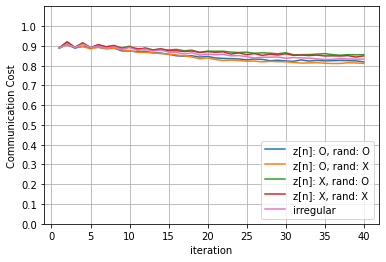

In [61]:
plt_CC(CommCost_iidG_test_mean[0], 'z[n]: O, rand: O', T, N, P, color[0])
plt_CC(CommCost_iidG_test_mean[1], 'z[n]: O, rand: X', T, N, P, color[1])
plt_CC(CommCost_iidG_test_mean[2], 'z[n]: X, rand: O', T, N, P, color[2])
plt_CC(CommCost_iidG_test_mean[3], 'z[n]: X, rand: X', T, N, P, color[3])
plt_CC(CommCost_iidG_test_mean[4], 'irregular', T, N, P, color[4])
plt.grid()

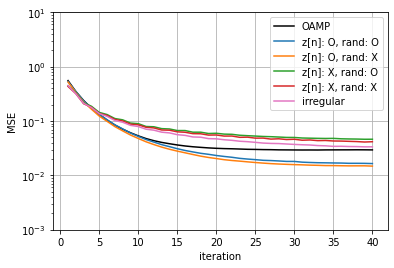

In [63]:
plt_MSE(MSE_iidG_oamp_mean, 'OAMP', T, 'black')
plt_MSE(MSE_iidG_test_mean[0], 'z[n]: O, rand: O', T, color[0])
plt_MSE(MSE_iidG_test_mean[1], 'z[n]: O, rand: X', T, color[1])
plt_MSE(MSE_iidG_test_mean[2], 'z[n]: X, rand: O', T, color[2])
plt_MSE(MSE_iidG_test_mean[3], 'z[n]: X, rand: X', T, color[3])
plt_MSE(MSE_iidG_test_mean[4], 'irregular', T, color[4])
plt.grid()